<b> Coding by python2.7
   
authors: Qixiang PENG, Zizhao LI

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV  
from matplotlib import pyplot as plt
%matplotlib inline

<b>load data

In [2]:
train = pd.read_csv('./data/train.csv')
# class between [1,9]
train_y = train['target'].apply(lambda s: int(s[-1:])).values
train_X = train.drop('id', axis=1)
train_X = train_X.drop('target', axis=1)
X_test = pd.read_csv('./data/test.csv')
X_test = X_test.drop('id', axis=1)
# split train set into 2 parts with same distribution: 80% train, 20% validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(train_X.values, train_y):
    X_train = train_X.values[train_index]
    X_val = train_X.values[test_index]

    y_train = train_y[train_index]
    y_val = train_y[test_index]

<b>use random forest

In [3]:
# original rf
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict_proba(X_val)
score = log_loss(y_val,pred)
print "The log loss is: " + str(score)

The log loss is: 1.43080654403


<b>we try to pick out some most important features, but not works.

In [19]:
importance = list(rf.feature_importances_)

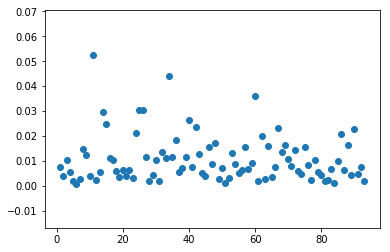

In [25]:
index = range(1,94)
plt.scatter(index, rf.feature_importances_)
plt.show()

<b> check if pca is useful, and results shows useless

In [12]:
for i in [10,20,30,40,50,60]:
    X_train_PCA = PCA(i).fit(X_train).transform(X_train)
    X_val_PCA = PCA(i).fit(X_train).transform(X_val)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    pred = rf.predict_proba(X_val)
    score = log_loss(y_val,pred)
    print str(i) + " The log loss is: " + str(score)

10 The log loss is: 1.47824431582
20 The log loss is: 1.46790040693
30 The log loss is: 1.46288704657
40 The log loss is: 1.39593422529
50 The log loss is: 1.46671294175
60 The log loss is: 1.46650075821


<b>fine-tune rf

In [19]:
# firstly we search the best n_estimator，to save time，we don't use cv and just compute once score in validation
score_list = []
for i in [100,200,300,400,500,600,700,800,900]:
    rf = RandomForestClassifier(n_estimators=i,n_jobs=2)
    rf.fit(X_train, y_train)
    pred = rf.predict_proba(X_val)
    score = log_loss(y_val, pred)
    score_list.append(score)

In [23]:
for i in [1000,1200,1300,1400,1500]:
    rf = RandomForestClassifier(n_estimators=i,n_jobs=2)
    rf.fit(X_train, y_train)
    pred = rf.predict_proba(X_val)
    score = log_loss(y_val, pred)
    score_list.append(score)

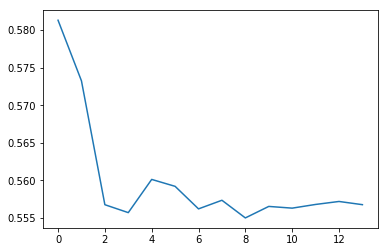

In [24]:
plt.plot(score_list)
plt.show()

In [4]:
# so the best n_estmators is 900, and we search best max_depth
score_list = []
for i in range(10,160,10):
    rf = RandomForestClassifier(n_estimators=900, max_depth=i, n_jobs=2)
    rf.fit(X_train, y_train)
    pred = rf.predict_proba(X_val)
    score = log_loss(y_val, pred)
    score_list.append(score)

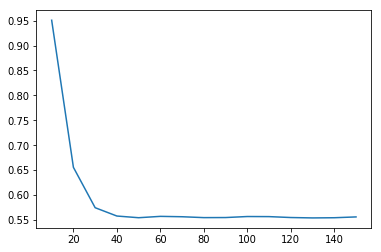

In [5]:
plt.plot(range(10,160,10),score_list)
plt.show()

In [7]:
# so the best max_depth is 50, and we search best max_features
score_list = []
for i in [0.1,0.2,0.3,0.4,0.5,0.6]:
    rf = RandomForestClassifier(n_estimators=900, max_depth=50, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict_proba(X_val)
    score = log_loss(y_val, pred)
    score_list.append(score)

In [9]:
for i in [0.7,0.8,0.9,1]:
    rf = RandomForestClassifier(n_estimators=900, max_depth=50, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict_proba(X_val)
    score = log_loss(y_val, pred)
    score_list.append(score)

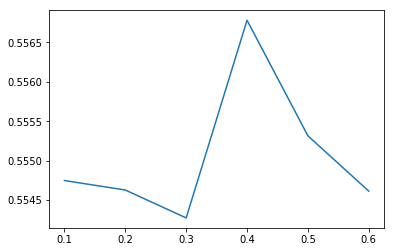

In [8]:
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],score_list)
plt.show()

In [41]:
# so the best max_features is 0.3. Due to time limit, we here only fine-tune these three hyper parameters.
rf = RandomForestClassifier(n_estimators=900, max_depth=50, max_features=0.3, n_jobs=-1)
rf.fit(X_train, y_train)
pred = rf.predict_proba(X_val)
score = log_loss(y_val, pred)
print "The log loss is: " + str(score)

The log loss is: 0.530867544064


<b>use calibrate

In [42]:
carf = CalibratedClassifierCV(rf, method="isotonic", cv=5)
carf.fit(X_train, y_train)
pred = carf.predict_proba(X_val)
score = log_loss(y_val, pred)
print "The log loss is: " + str(score)

The log loss is: 0.488653037065


<b> expot

In [43]:
result = carf.predict_proba(X_test)
columns = ["id","Class_1","Class_2","Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"]
rlt = np.zeros(result.shape[0] * 9).reshape((result.shape[0],9)).astype(float)

i = 0
for class_i in result:
    rlt[i] = class_i
    i += 1
    
r = []
i = 1
for class_i in rlt:
    p = [i] + list(map(str, class_i.tolist()))
    i += 1
    r.append(p)
r = np.array(r)

out = pd.DataFrame(r,columns = columns)
out.to_csv('result_RandomForest.csv',index = False)